In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="chemmodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
chemFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [7]:
chemFOSID = chemFOSID.filter(chemFOSID["Domain"]=="Chemistry").collect()

In [8]:
len(chemFOSID)

136

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(chemFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+---------+---------+
|   FOS_ID|   Domain|
+---------+---------+
|179104552|Chemistry|
| 31903555|Chemistry|
+---------+---------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered.count()

6924804

In [16]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [17]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [18]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [23]:
(sample1,sample2) = papers_filtered1.randomSplit([0.12,0.5])

In [24]:
sample1.count()

1340431

In [25]:
from sklearn import model_selection
from sklearn.model_selection import KFold 

In [26]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             9|
|             4|
|             0|
|             0|
+--------------+
only showing top 4 rows



In [27]:
sample1_pd = sample1.toPandas()

In [28]:
import numpy as np

In [29]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [30]:
from sklearn import metrics

In [31]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 1.7563261368917908)
('Mean Squared Error of EstimatedCount:', 381.435205542098)
('Root Mean Squared of with EstimatedCount:', 19.53036624188338)


In [32]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [33]:
sample1_pd.shape

(1340431, 12)

In [34]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

## Random Forest Regression

In [35]:
from sklearn.model_selection import KFold

In [36]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #print("X_train:", len(X_train), "X_test:", len(X_test))
    #print("y_train:", len(y_train), "y_test:", len(y_test))
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('Mean Absolute Error:', 2.9850797234939583)
('Mean Squared Error:', 131.52216620726102)
('Root Mean Squared Error:', 11.468311393019507)
('Mean Absolute Error:', 2.2603481970485966)
('Mean Squared Error:', 139.15946385612176)
('Root Mean Squared Error:', 11.796586957934984)
('Mean Absolute Error:', 0.6592061730837382)
('Mean Squared Error:', 7.384485854898274)
('Root Mean Squared Error:', 2.7174410490198815)
('Mean Absolute Error:', 2.794373448305072)
('Mean Squared Error:', 296.072276901151)
('Root Mean Squared Error:', 17.206750910649895)
('Mean Absolute Error:', 2.9844503108915537)
('Mean Squared Error:', 306.9375105996091)
('Root Mean Squared Error:', 17.519632147953594)


In [39]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 12.141744491715572)


In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
featureslist=sample1_pd.columns

In [42]:
importances = regressor.feature_importances_

In [43]:
import pandas as pd

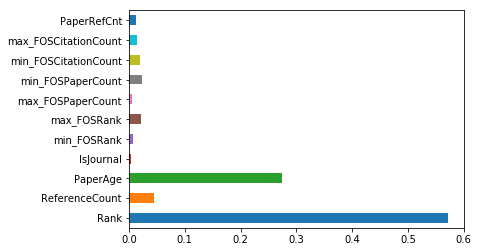

In [44]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [45]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.57139
Feature: 1, Score: 0.04555
Feature: 2, Score: 0.27435
Feature: 3, Score: 0.00430
Feature: 4, Score: 0.00709
Feature: 5, Score: 0.02184
Feature: 6, Score: 0.00623
Feature: 7, Score: 0.02286
Feature: 8, Score: 0.01961
Feature: 9, Score: 0.01369
Feature: 10, Score: 0.01308


## XGBoost Regression model

In [46]:
import xgboost as xgb

In [47]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [48]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 268087,  268088,  268089, ..., 1340428, 1340429, 1340430]), 'TEST:', array([     0,      1,      2, ..., 268084, 268085, 268086]))
('Mean Absolute Error of XGBoost Kfold:', 3.159447244634123)
('Mean Squared Error of XGBoost Kfold:', 174.4968455266639)
('Root Mean Squared Error of XGBoost Kfold:', 13.209725414506687)
('TRAIN:', array([      0,       1,       2, ..., 1340428, 1340429, 1340430]), 'TEST:', array([268087, 268088, 268089, ..., 536170, 536171, 536172]))
('Mean Absolute Error of XGBoost Kfold:', 2.3620001926714567)
('Mean Squared Error of XGBoost Kfold:', 142.5090994587869)
('Root Mean Squared Error of XGBoost Kfold:', 11.937717514616724)
('TRAIN:', array([      0,       1,       2, ..., 1340428, 1340429, 1340430]), 'TEST:', array([536173, 536174, 536175, ..., 804256, 804257, 804258]))
('Mean Absolute Error of XGBoost Kfold:', 0.6683669800412606)
('Mean Squared Error of XGBoost Kfold:', 7.543893457724273)
('Root Mean Squared Error of XGBoost Kfold:', 2.74661

In [49]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 12.789810869894234)


In [50]:
importances = regressor.feature_importances_

In [51]:
import pandas as pd

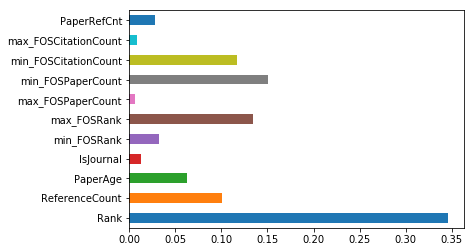

In [52]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 

In [53]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.34553
Feature: 1, Score: 0.10115
Feature: 2, Score: 0.06291
Feature: 3, Score: 0.01278
Feature: 4, Score: 0.03250
Feature: 5, Score: 0.13407
Feature: 6, Score: 0.00672
Feature: 7, Score: 0.15082
Feature: 8, Score: 0.11663
Feature: 9, Score: 0.00858
Feature: 10, Score: 0.02831


In [18]:
drop_cols = ["FOS_ID","PaperID","EstimatedCount","Domain","PaperYear","Volume","Issue"]
papers_filtered = papers_filtered.drop(*drop_cols)

In [19]:
papers_filtered1 = papers_filtered.select(["Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [20]:
from sklearn import model_selection
from sklearn.model_selection import KFold

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
len(papers_filtered.columns)

12

In [23]:
papers_pd = papers_filtered1.toPandas()

In [24]:
X = papers_pd.iloc[:, 0:11].values
y = papers_pd.iloc[:, 11].values

In [25]:
y[0:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [26]:
from sklearn.metrics import median_absolute_error

In [27]:
kfold = model_selection.KFold(n_splits=5, random_state=10)
model = RandomForestRegressor(n_estimators= 1000,max_depth=3)

In [28]:
results = model_selection.cross_val_score(model, X, y, cv=kfold,scoring="neg_mean_absolute_error")

In [29]:
print("Neg Mean Abosulte error: %.3f%% " % (results.mean()))

Neg Mean Abosulte error: -5.767% 


In [30]:
results

array([-5.03701221, -5.07693192, -5.07743707, -6.46592026, -7.1768768 ])